# Reinforcement Learning for Movie Recommendations with Learned Embeddings

This notebook implements a content-based movie recommender system using reinforcement learning (multi-armed bandits), building on the ideas introduced in the paper: "Reinforcement Learning Approaches to Movies Recommendation" by Carpentier et al. (2015).

This modernises the original approach by replacing PCA-engineered features with deep learned embeddings.

We train a self-supervised autoencoder to generate embeddings of movies based on their genres and release year. These embeddings are used in a contextual bandit setting to simulate personalised movie recommendations for new users.

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
import matplotlib as mpl

mpl.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'figure.figsize': (15, 6),
    'axes.spines.top': False,
    'axes.spines.right': False
})


import os
import random
import math
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import datetime


from multiprocessing import Pool, cpu_count
from functools import partial


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_squared_error


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, MinMaxScaler
from sklearn.preprocessing import normalize

In [3]:
SELECTED_DATA_DIR = "./selected-data/"
MOVIES_FILE = "best_movie_ratings_features.csv"
USERS_FILE = "users_ratings.csv"

In [4]:
movies = pd.read_csv(SELECTED_DATA_DIR + MOVIES_FILE, index_col=0)
movies.head()

,aka,genres,year,votes,rating
title,,,,,
The Shawshank Redemption (1994),"['Die Verurteilten (1995)', 'Die Verurteilten ...","['Crime', 'Drama']",[1994],1740070,9.3
The Dark Knight (2008),"['Batman Begins 2 (2005)', 'Batman: The Dark K...","['Action', 'Crime', 'Drama', 'Thriller']",[2008],1724382,9.0
Inception (2010),"['Inception: The IMAX Experience (2010)', ""Oli...","['Action', 'Adventure', 'Sci-Fi', 'Thriller']",[2010],1515276,8.8
Fight Club (1999),"['Fight Club (1999)', 'Fight Club (1999)', 'Fi...",['Drama'],[1999],1389487,8.8
Pulp Fiction (1994),"['Black Mask (1994)', 'Pulp Fiction (1994)', '...","['Crime', 'Drama']",[1994],1362518,8.9


In [5]:
users = pd.read_csv(SELECTED_DATA_DIR + USERS_FILE, index_col=0)
users.head()

,user,rating,link
movie,,,
The Pianist (2002),59957513,9,tt0253474
Schindler's List (1993),59957513,9,tt0108052
Reservoir Dogs (1992),59957513,7,tt0105236
Captain Phillips (2013),59957513,8,tt1535109
Goodfellas (1990),59957513,8,tt0099685


# Learning Dense Movie Representations with an Autoencoder

In [6]:
# Preprocess movie features for autoencoder
# Genre encoding
genre_mlb = MultiLabelBinarizer()
genre_features = genre_mlb.fit_transform(movies['genres'])

# Year encoding
year_encoder = OneHotEncoder(sparse_output=False)
year_features = year_encoder.fit_transform(movies[['year']])

# Final input
import numpy as np
X = np.hstack([genre_features, year_features])

X.shape

(1000, 71)

Feature Vector: 71-Dimensional Encoding of Genre and Year

In [7]:
len(genre_mlb.classes_)

35

In [8]:
len(year_encoder.categories_[0])

36

### Autoencoder Architecture

In [9]:
class MovieAutoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 48),
            nn.ReLU(),
            nn.Linear(48, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

### Train Autoencoder

In [10]:
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = MovieAutoencoder(input_dim=X.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    for batch in dataloader:
        inputs = batch[0]
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.2345
Epoch 2, Loss: 0.1774
Epoch 3, Loss: 0.1038
Epoch 4, Loss: 0.0948
Epoch 5, Loss: 0.0856
Epoch 6, Loss: 0.0813
Epoch 7, Loss: 0.0787
Epoch 8, Loss: 0.0755
Epoch 9, Loss: 0.0684
Epoch 10, Loss: 0.0725
Epoch 11, Loss: 0.0711
Epoch 12, Loss: 0.0635
Epoch 13, Loss: 0.0665
Epoch 14, Loss: 0.0601
Epoch 15, Loss: 0.0517
Epoch 16, Loss: 0.0550
Epoch 17, Loss: 0.0561
Epoch 18, Loss: 0.0508
Epoch 19, Loss: 0.0510
Epoch 20, Loss: 0.0476
Epoch 21, Loss: 0.0435
Epoch 22, Loss: 0.0428
Epoch 23, Loss: 0.0385
Epoch 24, Loss: 0.0377
Epoch 25, Loss: 0.0385
Epoch 26, Loss: 0.0323
Epoch 27, Loss: 0.0332
Epoch 28, Loss: 0.0352
Epoch 29, Loss: 0.0316
Epoch 30, Loss: 0.0336
Epoch 31, Loss: 0.0317
Epoch 32, Loss: 0.0333
Epoch 33, Loss: 0.0231
Epoch 34, Loss: 0.0270
Epoch 35, Loss: 0.0262
Epoch 36, Loss: 0.0241
Epoch 37, Loss: 0.0243
Epoch 38, Loss: 0.0251
Epoch 39, Loss: 0.0251
Epoch 40, Loss: 0.0254
Epoch 41, Loss: 0.0244
Epoch 42, Loss: 0.0225
Epoch 43, Loss: 0.0225
Epoch 44, Loss: 0.02

### Save model

In [ ]:
torch.save(model, "movie_autoencoder_full.pt")

### Generate embeddings for all movies

In [11]:
with torch.no_grad():
    _, embeddings = model(X_tensor)
    movie_embeddings = {
        title: embeddings[i].numpy()
        for i, title in enumerate(movies.index)
    }

In [12]:
movie_embeddings['The Shawshank Redemption (1994)']

array([-4.8128324, -1.8707842, -1.365247 , -5.8485284,  6.4465714,
        2.7075052,  3.8167408, -6.543528 , -3.0155413, -4.1314573,
       -0.825476 ,  1.1428757,  6.703263 ,  3.8222628, -1.2189282,
       -2.9874616], dtype=float32)

In [13]:
for title, vec in list(movie_embeddings.items())[:3]:
    print(f"{title}: L2 norm = {np.linalg.norm(vec):.4f}")

The Shawshank Redemption (1994): L2 norm = 16.3435
The Dark Knight (2008): L2 norm = 23.3953
Inception (2010): L2 norm = 22.1277


### Normalize movie embeddings (L2 norm)

In [14]:
embedding_matrix = np.array(list(movie_embeddings.values()))
embedding_matrix = normalize(embedding_matrix, axis=1)

normalized_movie_embeddings = {
    title: vec for title, vec in zip(movie_embeddings.keys(), embedding_matrix)
}

normalized_movie_embeddings['The Shawshank Redemption (1994)']

array([-0.29447952, -0.11446641, -0.08353445, -0.35784996,  0.39444202,
        0.16566229,  0.23353234, -0.40037444, -0.18450989, -0.2527887 ,
       -0.05050784,  0.06992836,  0.41014802,  0.23387021, -0.07458173,
       -0.1827918 ], dtype=float32)

In [15]:
for title, vec in list(normalized_movie_embeddings.items())[:3]:
    print(f"{title}: L2 norm = {np.linalg.norm(vec):.4f}")

The Shawshank Redemption (1994): L2 norm = 1.0000
The Dark Knight (2008): L2 norm = 1.0000
Inception (2010): L2 norm = 1.0000


In [16]:
normalized_movie_embeddings = pd.DataFrame.from_dict(
    normalized_movie_embeddings, orient='index',
    columns=[f'x{i}' for i in range(16)]
)
normalized_movie_embeddings

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
The Shawshank Redemption (1994),-0.294480,-0.114466,-0.083534,-0.357850,0.394442,0.165662,0.233532,-0.400374,-0.184510,-0.252789,-0.050508,0.069928,0.410148,0.233870,-0.074582,-0.182792
The Dark Knight (2008),-0.360440,0.048520,-0.037713,-0.196924,0.306945,-0.045565,0.395572,-0.402200,-0.272922,-0.074917,0.093100,0.163002,0.338376,0.278625,-0.259177,-0.195843
Inception (2010),-0.362572,0.045628,-0.033615,0.009945,0.077699,-0.300296,0.429652,-0.405114,-0.139712,0.077736,0.212449,0.191873,0.254000,0.193210,-0.452836,-0.076673
Fight Club (1999),-0.217766,-0.215113,-0.099522,-0.314262,0.517434,0.313406,0.096836,-0.323916,0.066249,-0.213381,-0.152562,-0.069293,0.445906,0.148578,-0.022259,-0.134088
Pulp Fiction (1994),-0.294480,-0.114466,-0.083534,-0.357850,0.394442,0.165662,0.233532,-0.400374,-0.184510,-0.252789,-0.050508,0.069928,0.410148,0.233870,-0.074582,-0.182792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scream 2 (1997),-0.179131,-0.245336,-0.049057,0.029789,0.306030,-0.288650,0.364239,-0.271521,-0.146439,-0.524265,0.015441,0.083549,0.429467,-0.128020,-0.127871,-0.019049
Clueless (1995),-0.138790,-0.291137,-0.257369,-0.472834,0.209279,0.033941,0.337521,-0.316595,-0.056521,-0.168663,0.146263,0.246176,0.352606,0.073217,-0.238580,-0.216366
The Lovely Bones (2009),-0.354370,-0.016105,-0.133029,-0.076389,0.437137,-0.156868,0.342604,-0.457420,-0.277342,-0.253634,0.074243,0.149920,0.311071,0.158786,-0.044456,-0.123011
27 Dresses (2008),-0.143441,-0.302913,-0.270286,-0.474568,0.206670,0.037646,0.320514,-0.328745,-0.040816,-0.158474,0.151483,0.235872,0.349238,0.075294,-0.241144,-0.208130


# Content-Based Reinforcement Learning with Learned Movie Embeddings

In [17]:
# --- UTILITY FUNCTIONS ---
def compute_utility(user_features, movie_features, epoch, s):
    return user_features.dot(movie_features) * (1 - math.exp(-epoch / s))

def compute_UCB(epoch, Nt):
    return math.sqrt((2 * math.log2(epoch + 1)) / (Nt * epoch)) if Nt > 0 else 0

def get_movie_features(title):
    return normalized_movie_embeddings.loc[title].values.astype(np.float32)

def iterative_mean(old, new, t):
    return ((t - 1) / t) * old + (1 / t) * new

def update_features(user_features, movie_features, rating, t):
    return iterative_mean(user_features, movie_features * rating, t + 1)

# --- POLICY CLASSES ---
class Algorithm:
    def update_features(self, user_features, movie_features, rating, t):
        return update_features(user_features, movie_features, rating, t)

    def compute_utility(self, user_features, movie_features, epoch, s):
        return compute_utility(user_features, movie_features, epoch, s)

class RandomPolicy(Algorithm):
    def choice(self, user_features, movies, epoch, s):
        return movies.sample(1)

class GreedyPolicy(Algorithm):
    def choice(self, user_features, movies, epoch, s):
        return best_contentbased_recommendation(user_features, movies, epoch, s)

class EpsilonGreedyPolicy(Algorithm):
    def __init__(self, epsilon=0.3):
        self.epsilon = epsilon

    def choice(self, user_features, movies, epoch, s):
        if random.random() < self.epsilon:
            return movies.sample(1)
        else:
            return best_contentbased_recommendation(user_features, movies, epoch, s)

In [18]:
# --- RECOMMENDATION LOGIC ---
def best_contentbased_recommendation(user_features, movies, epoch, s):
    utilities = np.zeros(len(movies))
    for i, (title, movie) in enumerate(movies.iterrows()):
        features = get_movie_features(title)
        utilities[i] = compute_utility(user_features, features, epoch - movie.last_t, s)
        utilities[i] += compute_UCB(epoch, movie.Nt)
    return movies.iloc[[utilities.argmax()]]

In [19]:
# --- SIMULATION ---
def reinforcement_learning(user, movies, algorithm, s, steps):
    algo = algorithm() if callable(algorithm) else algorithm
    user_features = np.zeros(normalized_movie_embeddings.shape[1])

    movies_sim = movies.copy()
    movies_sim['last_t'] = 1
    movies_sim['t'] = range(len(movies_sim))
    movies_sim['rating'] = user['rating']
    movies_sim['Nt'] = 0

    cumregret, accuracy_rmse, avg_rating, timestamps = [0], [0], [0], []
    watched_titles = set()

    for t in range(steps):
        start = datetime.datetime.now()

        rec = algo.choice(user_features, movies_sim, t + 1, s)
        rec_title = rec.index[0]
        rec_feat = get_movie_features(rec_title)

        actual_rating = user.loc[rec_title, 'rating']
        user_features = algo.update_features(user_features, rec_feat, actual_rating, t)
        utility = algo.compute_utility(user_features, rec_feat, t + 1, s)

        watched_titles.add(rec_title)

        unwatched = user[~user.index.isin(watched_titles)]
        if len(unwatched) > 0:
            best_possible_rating = unwatched['rating'].max()
        else:
            best_possible_rating = actual_rating

        true_regret = best_possible_rating - actual_rating

        cumregret.append(cumregret[-1] + true_regret)
        accuracy_rmse.append((actual_rating - utility) ** 2)
        avg_rating.append(actual_rating)

        movies_sim.loc[rec.index, 'last_t'] = t
        movies_sim.loc[rec.index, 'Nt'] += 1
        timestamps.append((datetime.datetime.now() - start).total_seconds())

    return {
        'cumregret': cumregret,
        'accuracy_rmse': accuracy_rmse,
        'avg_rating': avg_rating,
        'timediff': timestamps
    }

In [20]:
# --- MULTI-USER SIMULATION ---
def simulate_multiple_users(users_df, movies_df, algorithms, steps=20, n_users=10, s=200):
    results_all = []
    users_sample = users_df[users_df.user.isin(
        pd.Series(users_df.user.unique()).sample(n_users, random_state=42)
    )]

    movies_sample = movies_df.loc[users_sample.index.unique()]

    for algo in tqdm(algorithms):
        algo_results = []
        for user_id in users_sample.user.unique():
            user = users_sample[users_sample.user == user_id]
            movies_user = movies_sample.loc[movies_sample.index.isin(user.index)]
            res = reinforcement_learning(user, movies_user, algo, s, steps)
            algo_results.append(res)
        results_all.append(algo_results)

    return results_all

# Results

In [21]:
ALGOS = [GreedyPolicy, EpsilonGreedyPolicy, RandomPolicy]
ALGOS_NAME = ['Greedy', 'EpsilonGreedy', 'Random']
results = simulate_multiple_users(users, normalized_movie_embeddings, ALGOS, steps=500, n_users=5, s=200)

100%|██████████| 3/3 [01:01<00:00, 20.57s/it]


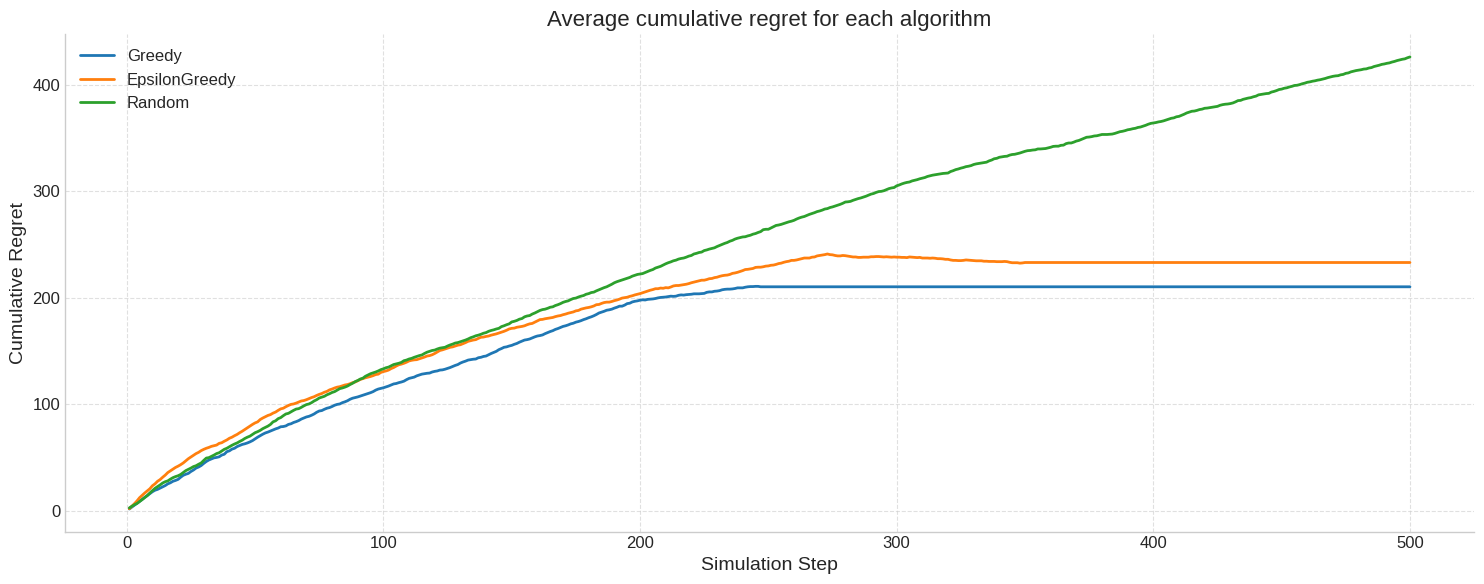

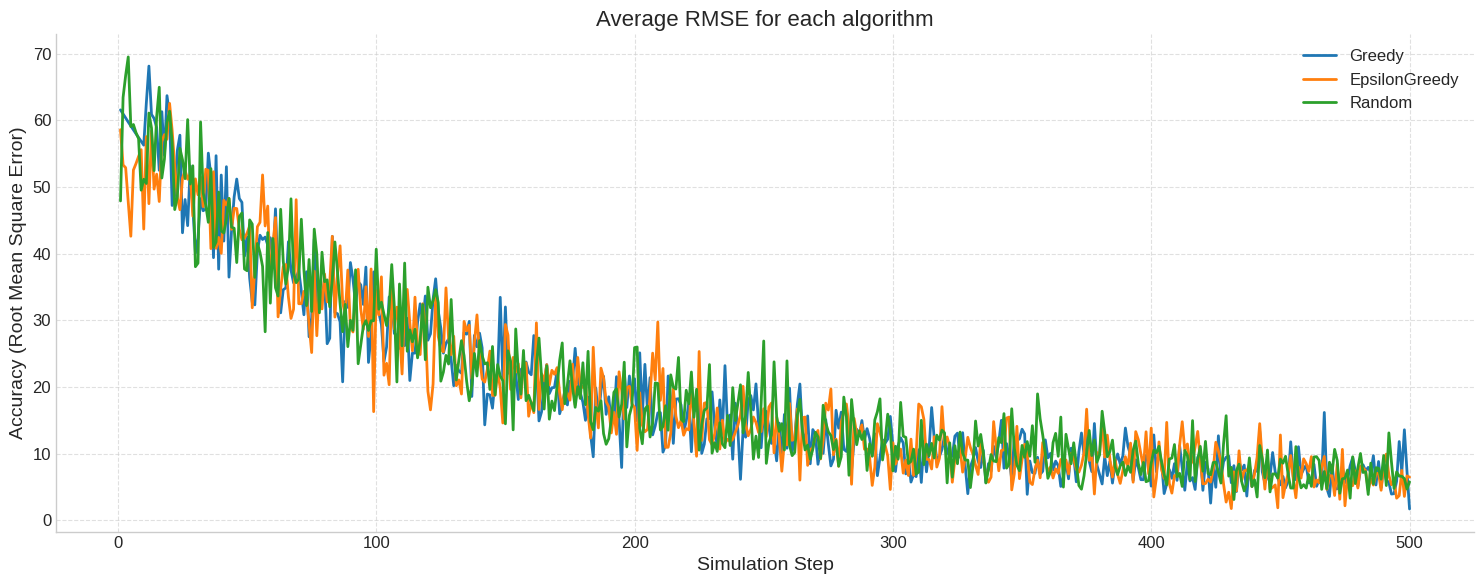

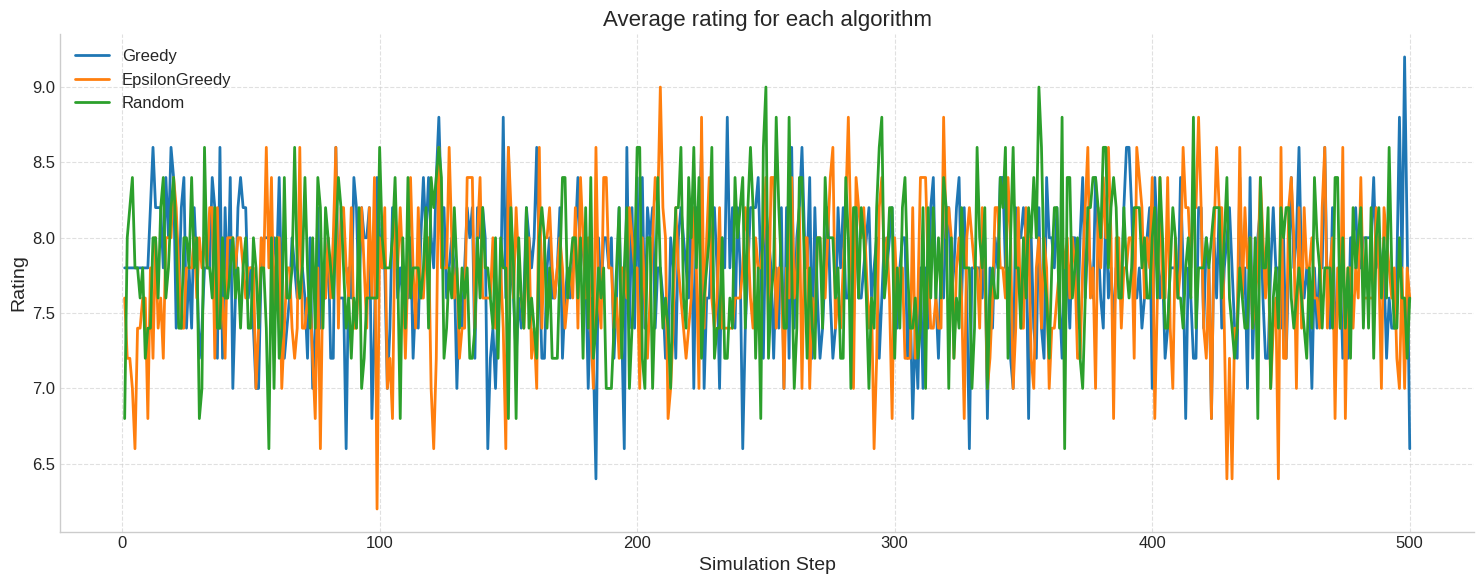

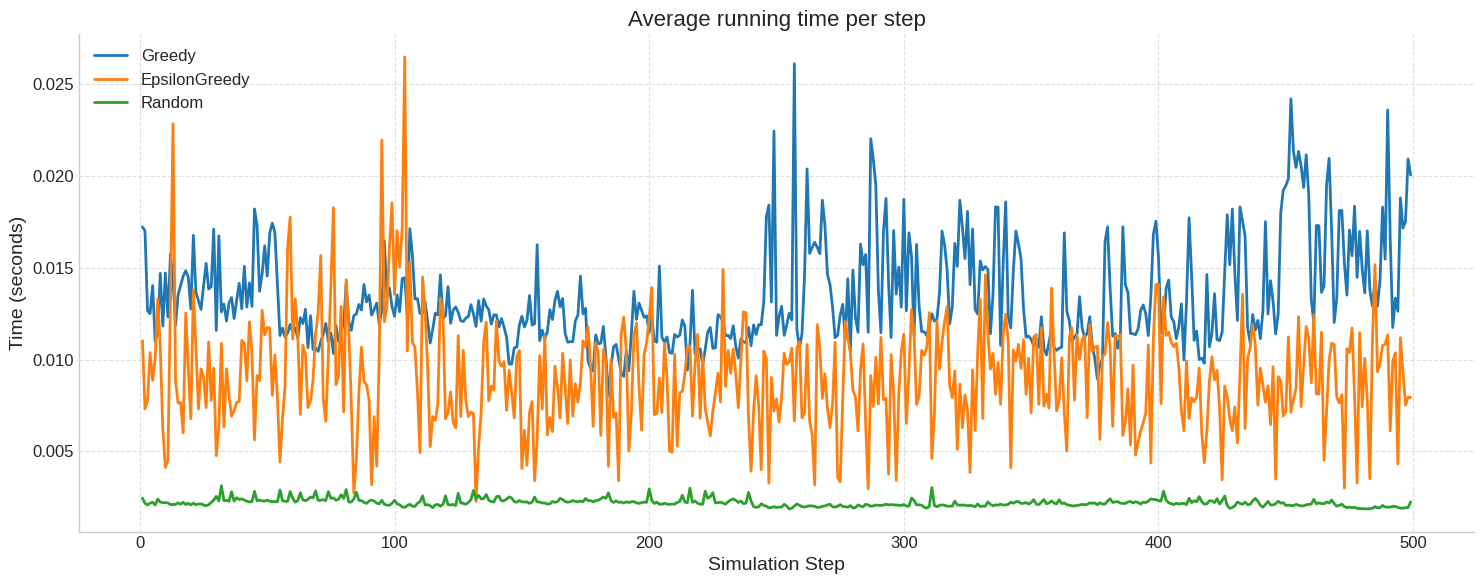

In [30]:
METRICS = ['cumregret', 'accuracy_rmse', 'avg_rating', 'timediff']
TITLE_GRAPH = [
    'Average cumulative regret for each algorithm',
    'Average RMSE for each algorithm',
    'Average rating for each algorithm',
    'Average running time per step'
]
X_AXIS = [
    'Cumulative Regret',
    'Accuracy (Root Mean Square Error)',
    'Rating',
    'Time (seconds)'
]

assert len(METRICS) == len(TITLE_GRAPH) == len(X_AXIS)


for metric, title, ylabel in zip(METRICS, TITLE_GRAPH, X_AXIS):
    plt.figure()

    for i, algoname in enumerate(ALGOS_NAME):
        metric_matrix = np.array([user_result[metric] for user_result in results[i]])
        avg_metric = np.mean(metric_matrix, axis=0)[1:]
        plt.plot(range(1, len(avg_metric) + 1), avg_metric, label=algoname, linewidth=2)

    plt.title(title)
    plt.xlabel('Simulation Step')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()